# Import Package

In [1]:
# Evaluation Metric Packages
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Dataset loading Packages
from zipfile import ZipFile
from PIL import Image
from io import BytesIO

# Utilities
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Neural Network Learning Packages
import tensorflow as tf
from tensorflow.keras import backend as K

print("Num GPUs Available: ",
      len(tf.config.experimental.list_physical_devices('GPU')))
tf.random.set_seed(0)

Num GPUs Available:  3


In [2]:
r_seed = 0
np.random.seed(r_seed)

omniglot_data_path = 'data/1_raw/omniglot/images_evaluation.zip'
sample_size = 10000

# Preparing Data

## MNIST and MNIST-Noise and Noise

In [3]:
mnist = tf.keras.datasets.mnist

(x_mnist_train, y_mnist_train), (x_mnist_test,
                                 y_mnist_test) = mnist.load_data()
x_mnist_train, x_mnist_test = x_mnist_train / 255.0, x_mnist_test / 255.0

# introduce noise to mnist
x_mnist_noise_test = x_mnist_test.copy()
random_noise = np.random.uniform(
    0, 1, x_mnist_noise_test[np.where(x_mnist_noise_test == 0)].shape[0])
x_mnist_noise_test[np.where(x_mnist_noise_test == 0)] = random_noise

x_noise_test = np.random.uniform(0, 1, (sample_size, 28, 28))

In [4]:
for i in range(4):
    im = Image.fromarray(np.uint8(x_mnist_test[i]*255))
    display(im)
    
for i in range(4):
    im = Image.fromarray(np.uint8(x_mnist_noise_test[i]*255))
    display(im)
    
for i in range(4):
    im = Image.fromarray(np.uint8(x_noise_test[i]*255))
    display(im)

## Omniglot

In [5]:
def load_omniglot_eval(data_path):
    omniglot_data_list = []
    with ZipFile(data_path) as zf:
        for filename in zf.namelist():
            if '.png' in filename:
                zip_data = zf.read(filename)
                bytes_io = BytesIO(zip_data)
                pil_img = Image.open(bytes_io)
                pil_img = pil_img.resize((28, 28))
                omniglot_data_list.append([1 - np.array(pil_img) * 1.0])

    omniglot_data = np.concatenate(omniglot_data_list)
    return omniglot_data


omniglot_data = load_omniglot_eval(omniglot_data_path)
sample_idx = np.random.permutation(omniglot_data.shape[0])[:sample_size]
x_omniglot_test = omniglot_data[sample_idx]
print(omniglot_data.shape)

(13180, 28, 28)


In [6]:
for i in range(4):
    im = Image.fromarray(np.uint8(x_omniglot_test[i]*255))
    display(im)

# Feature Encoding

In [7]:
x_mnist_train = x_mnist_train.reshape(-1, 28, 28, 1)
x_mnist_test = x_mnist_test.reshape(-1, 28, 28, 1)
x_omniglot_test = x_omniglot_test.reshape(-1, 28, 28, 1)
x_mnist_noise_test = x_mnist_noise_test.reshape(-1, 28, 28, 1)
x_noise_test = x_noise_test.reshape(-1, 28, 28, 1)

In [8]:
basic_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=100,
                           kernel_size=(3, 3),
                           activation="relu",
                           input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Activation(activation='softmax')
])

# basic_model learning configurations
basic_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# set layer output as a second Model
encoder = tf.keras.models.Model(inputs=basic_model.layers[0].input,
                                outputs=basic_model.layers[-2].output)

K.set_value(basic_model.optimizer.learning_rate, 0.001)
basic_model.fit(x_mnist_train, y_mnist_train, epochs=5)
basic_model.evaluate(x_mnist_test, y_mnist_test, verbose=2)

Epoch 1/5
1875/1875 [==============================] - 10s 4ms/step - loss: 0.2395 - accuracy: 0.9256
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0472 - accuracy: 0.9864
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0343 - accuracy: 0.9899
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0267 - accuracy: 0.9916
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0222 - accuracy: 0.9931
313/313 - 1s - loss: 0.0440 - accuracy: 0.9861


[0.04397447034716606, 0.9861000180244446]

In [9]:
e_mnist_train = encoder.predict(x_mnist_train)
e_mnist_test = encoder.predict(x_mnist_test)
e_omniglot_test = encoder.predict(x_omniglot_test)
e_mnist_noise_test = encoder.predict(x_mnist_noise_test)
e_noise_test = encoder.predict(x_noise_test)

# Openset Sample Enrichment

In [10]:
from aosr_utility import sample_enrichment_IF

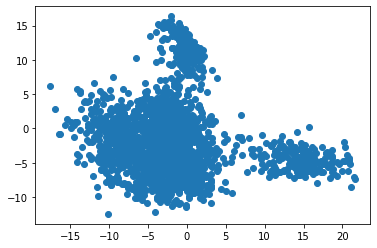

/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


(203649,)


In [11]:
tf.random.set_seed(0)

plt.scatter(e_mnist_train[:2000, 0], e_mnist_train[:2000, 1])
plt.show()

z_q_sample, z_q_coe = sample_enrichment_IF(0, e_mnist_train, 240000)

# Openset Learning

In [12]:
from aosr_utility import aosr_risk

In [13]:
def mnist_exp(r_seed, beta=0.1, t=0.1):
    
    z_q_weight = 1 - z_q_coe * 1.0
    tau = np.sort(z_q_weight)[int(z_q_weight.shape[0] * t)]

    # Unknown Samples
    cond1 = (z_q_weight > tau)
    cond1 = np.squeeze(cond1)
    # Known Samples
    cond2 = (z_q_weight <= tau)
    cond2 = np.squeeze(cond2)
    # Wipe Known Samples
    z_q_weight[cond2] = 0
    # Balance the weights
    z_q_weight = z_q_weight * (z_q_weight.shape[0] / z_q_weight.sum())

    # ================================================================== #
    #                                 FYI                                #
    # Design the Open-set Learning Model is a complicated task           #
    # At this stage, we only evaluate the openset learning loss          #
    # How to design proper openset model is consider as our future work  #
    # Since we use the closed-set output as our encoder, the Open-set    # 
    # the Open-set neural network is relatively simple                   #
    # ================================================================== #
    tf.random.set_seed(r_seed)
    detetor = tf.keras.models.Sequential([
        tf.keras.layers.Dense(11),
        tf.keras.layers.Activation(activation='softmax')
    ])

    detetor.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
    detetor.fit(e_mnist_train, y_mnist_train * 1.0, epochs=2)

    detetor.compile(optimizer='adam',
                    loss=aosr_risk(detetor, z_q_sample, z_q_weight, e_mnist_train, beta, 10),
                    metrics=['accuracy'])

    K.set_value(detetor.optimizer.learning_rate, 0.001)
    detetor.fit(e_mnist_train, y_mnist_train * 1.0, epochs=25)


    mniTe_pred = detetor.predict(e_mnist_test)
    mniTe_pred = mniTe_pred.argmax(axis=1)
    print('x_mnist_test acc', accuracy_score(y_mnist_test, mniTe_pred))

    mniTr_pred = detetor.predict(e_mnist_train)
    mniTr_pred = mniTr_pred.argmax(axis=1)
    print('x_mnist_train detection rate', (mniTr_pred == 10).sum() / 60000)
    print('x_mnist_test detection rate', (mniTe_pred == 10).sum() / 10000)

    omnig_pred = detetor.predict(e_omniglot_test)
    omnig_pred = omnig_pred.argmax(axis=1)
    print('x_omniglot_test detection rate', (omnig_pred == 10).sum() / 10000)

    mnisN_pred = detetor.predict(e_mnist_noise_test)
    mnisN_pred = mnisN_pred.argmax(axis=1)
    print('x_mnist_noise_test detection rate', (mnisN_pred == 10).sum() / 10000)

    noise_pred = detetor.predict(e_noise_test)
    noise_pred = noise_pred.argmax(axis=1)
    print('x_noise_test detection rate', (noise_pred == 10).sum() / 10000)

    sample_size = 10000
    true_label = np.zeros(sample_size*2) + 10
    true_label[:sample_size] = y_mnist_test

    omnig_f1 = f1_score(true_label, np.concatenate([mniTe_pred,omnig_pred]), average='macro')
    mnisN_f1 = f1_score(true_label, np.concatenate([mniTe_pred,mnisN_pred]), average='macro')
    noise_f1 = f1_score(true_label, np.concatenate([mniTe_pred,noise_pred]), average='macro')

    playground_result = pd.DataFrame()
    playground_result['detector'] = ['aosr_risk']
    playground_result['omnig_f1'] = [omnig_f1]
    playground_result['mnisN_f1'] = [mnisN_f1]
    playground_result['noise_f1'] = [noise_f1]
    return playground_result

## Parameter Beta Analysis

In [14]:
result_list =[]
t_list = [0.05, 0.1, 0.15, 0.2, 0.25]
for t in t_list:
    for itr in range(5):
        result_df = mnist_exp(itr, 0.1, t)
        result_df['t'] = t
        result_list.append(result_df)
result = pd.concat(result_list, axis=0)
print(result.mean())
print(result.std())
result

Epoch 1/2
1875/1875 [==============================] - 2s 773us/step - loss: 1.9908 - accuracy: 0.6744
Epoch 2/2
1875/1875 [==============================] - 1s 762us/step - loss: 0.0315 - accuracy: 0.9920
Epoch 1/25
1875/1875 [==============================] - 4s 2ms/step - loss: 228586358.6738 - accuracy: 0.9941
Epoch 2/25
1875/1875 [==============================] - 3s 2ms/step - loss: 34491.6937 - accuracy: 0.9945
Epoch 3/25
1875/1875 [==============================] - 3s 2ms/step - loss: 33951.7259 - accuracy: 0.9943
Epoch 4/25
1875/1875 [==============================] - 3s 2ms/step - loss: 31999.9678 - accuracy: 0.9937
Epoch 5/25
1875/1875 [==============================] - 3s 2ms/step - loss: 13653.3836 - accuracy: 0.9934
Epoch 6/25
1875/1875 [==============================] - 3s 2ms/step - loss: 5797.0603 - accuracy: 0.9935
Epoch 7/25
1875/1875 [==============================] - 3s 2ms/step - loss: 3179.4086 - accuracy: 0.9936
Epoch 8/25
1875/1875 [============================

1875/1875 [==============================] - 6s 3ms/step - loss: 1.4990 - accuracy: 0.9135
Epoch 20/25
1875/1875 [==============================] - 5s 3ms/step - loss: 1.3432 - accuracy: 0.8967
Epoch 21/25
1875/1875 [==============================] - 6s 3ms/step - loss: 1.2735 - accuracy: 0.8944
Epoch 22/25
1875/1875 [==============================] - 6s 3ms/step - loss: 1.2621 - accuracy: 0.8922
Epoch 23/25
1875/1875 [==============================] - 6s 3ms/step - loss: 1.2685 - accuracy: 0.8913
Epoch 24/25
1875/1875 [==============================] - 5s 3ms/step - loss: 1.2617 - accuracy: 0.8920
Epoch 25/25
1875/1875 [==============================] - 6s 3ms/step - loss: 1.2624 - accuracy: 0.8908
x_mnist_test acc 0.8961
x_mnist_train detection rate 0.10146666666666666
x_mnist_test detection rate 0.1002
x_omniglot_test detection rate 0.7463
x_mnist_noise_test detection rate 1.0
x_noise_test detection rate 1.0
Epoch 1/2
1875/1875 [==============================] - 2s 989us/step - loss

1875/1875 [==============================] - 5s 3ms/step - loss: 207.3559 - accuracy: 0.9902
Epoch 11/25
1875/1875 [==============================] - 6s 3ms/step - loss: 77.1286 - accuracy: 0.9875
Epoch 12/25
1875/1875 [==============================] - 6s 3ms/step - loss: 34.0218 - accuracy: 0.9837
Epoch 13/25
1875/1875 [==============================] - 6s 3ms/step - loss: 14.2734 - accuracy: 0.9745
Epoch 14/25
1875/1875 [==============================] - 5s 3ms/step - loss: 6.7743 - accuracy: 0.9628
Epoch 15/25
1875/1875 [==============================] - 6s 3ms/step - loss: 4.0018 - accuracy: 0.9486
Epoch 16/25
1875/1875 [==============================] - 6s 3ms/step - loss: 2.7091 - accuracy: 0.9392
Epoch 17/25
1875/1875 [==============================] - 6s 3ms/step - loss: 2.0568 - accuracy: 0.9294
Epoch 18/25
1875/1875 [==============================] - 5s 3ms/step - loss: 1.8348 - accuracy: 0.9280
Epoch 19/25
1875/1875 [==============================] - 6s 3ms/step - loss: 1.6

1875/1875 [==============================] - 7s 3ms/step - loss: 166386895.2111 - accuracy: 0.9939
Epoch 2/25
1875/1875 [==============================] - 6s 3ms/step - loss: 14850.5821 - accuracy: 0.9940
Epoch 3/25
1875/1875 [==============================] - 6s 3ms/step - loss: 14742.1860 - accuracy: 0.9947
Epoch 4/25
1875/1875 [==============================] - 5s 2ms/step - loss: 14467.5502 - accuracy: 0.9944
Epoch 5/25
1875/1875 [==============================] - 6s 3ms/step - loss: 13338.7743 - accuracy: 0.9935
Epoch 6/25
1875/1875 [==============================] - 6s 3ms/step - loss: 11551.4784 - accuracy: 0.9931
Epoch 7/25
1875/1875 [==============================] - 6s 3ms/step - loss: 2676.3595 - accuracy: 0.9924
Epoch 8/25
1875/1875 [==============================] - 5s 3ms/step - loss: 1440.8035 - accuracy: 0.9918
Epoch 9/25
1875/1875 [==============================] - 6s 3ms/step - loss: 565.6497 - accuracy: 0.9910
Epoch 10/25
1875/1875 [==============================] - 

1875/1875 [==============================] - 5s 3ms/step - loss: 1.3072 - accuracy: 0.9058
Epoch 22/25
1875/1875 [==============================] - 6s 3ms/step - loss: 1.2547 - accuracy: 0.9008
Epoch 23/25
1875/1875 [==============================] - 6s 3ms/step - loss: 1.2407 - accuracy: 0.9015
Epoch 24/25
1875/1875 [==============================] - 6s 3ms/step - loss: 1.2518 - accuracy: 0.8984
Epoch 25/25
1875/1875 [==============================] - 5s 3ms/step - loss: 1.2470 - accuracy: 0.8982
x_mnist_test acc 0.8932
x_mnist_train detection rate 0.10343333333333334
x_mnist_test detection rate 0.1023
x_omniglot_test detection rate 0.7105
x_mnist_noise_test detection rate 1.0
x_noise_test detection rate 1.0
Epoch 1/2
1875/1875 [==============================] - 2s 939us/step - loss: 2.5699 - accuracy: 0.6630
Epoch 2/2
1875/1875 [==============================] - 2s 927us/step - loss: 0.0346 - accuracy: 0.9919
Epoch 1/25
1875/1875 [==============================] - 7s 3ms/step - loss:

1875/1875 [==============================] - 6s 3ms/step - loss: 40.3618 - accuracy: 0.9826
Epoch 13/25
1875/1875 [==============================] - 6s 3ms/step - loss: 15.2453 - accuracy: 0.9740
Epoch 14/25
1875/1875 [==============================] - 6s 3ms/step - loss: 6.8074 - accuracy: 0.9630
Epoch 15/25
1875/1875 [==============================] - 5s 2ms/step - loss: 3.9539 - accuracy: 0.9518
Epoch 16/25
1875/1875 [==============================] - 6s 3ms/step - loss: 2.5161 - accuracy: 0.9414
Epoch 17/25
1875/1875 [==============================] - 6s 3ms/step - loss: 1.9838 - accuracy: 0.9334
Epoch 18/25
1875/1875 [==============================] - 6s 3ms/step - loss: 1.7810 - accuracy: 0.9284
Epoch 19/25
1875/1875 [==============================] - 5s 2ms/step - loss: 1.5821 - accuracy: 0.9230
Epoch 20/25
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4054 - accuracy: 0.9141
Epoch 21/25
1875/1875 [==============================] - 6s 3ms/step - loss: 1.2921

1875/1875 [==============================] - 6s 3ms/step - loss: 137628.2856 - accuracy: 0.9947
Epoch 4/25
1875/1875 [==============================] - 6s 3ms/step - loss: 118000.3370 - accuracy: 0.9943
Epoch 5/25
1875/1875 [==============================] - 5s 3ms/step - loss: 73276.1761 - accuracy: 0.9933
Epoch 6/25
1875/1875 [==============================] - 5s 3ms/step - loss: 150067.3989 - accuracy: 0.9822
Epoch 7/25
1875/1875 [==============================] - 6s 3ms/step - loss: 695.2936 - accuracy: 0.9706
Epoch 8/25
1875/1875 [==============================] - 6s 3ms/step - loss: 663.1611 - accuracy: 0.9709
Epoch 9/25
1875/1875 [==============================] - 6s 3ms/step - loss: 643.7748 - accuracy: 0.9701
Epoch 10/25
1875/1875 [==============================] - 4s 2ms/step - loss: 500.9043 - accuracy: 0.9703
Epoch 11/25
1875/1875 [==============================] - 4s 2ms/step - loss: 282.0443 - accuracy: 0.9666
Epoch 12/25
1875/1875 [==============================] - 4s 2m

1875/1875 [==============================] - 3s 2ms/step - loss: 1.2295 - accuracy: 0.9055
Epoch 24/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.2312 - accuracy: 0.9053
Epoch 25/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.2359 - accuracy: 0.9033
x_mnist_test acc 0.9068
x_mnist_train detection rate 0.08925
x_mnist_test detection rate 0.0892
x_omniglot_test detection rate 0.7097
x_mnist_noise_test detection rate 1.0
x_noise_test detection rate 1.0
Epoch 1/2
1875/1875 [==============================] - 2s 715us/step - loss: 2.6906 - accuracy: 0.6252
Epoch 2/2
1875/1875 [==============================] - 1s 725us/step - loss: 0.0403 - accuracy: 0.9902
Epoch 1/25
1875/1875 [==============================] - 4s 2ms/step - loss: 402077485.3774 - accuracy: 0.9873
Epoch 2/25
1875/1875 [==============================] - 3s 2ms/step - loss: 24744.2339 - accuracy: 0.9846
Epoch 3/25
1875/1875 [==============================] - 3s 2ms/step - loss: 2

1875/1875 [==============================] - 3s 2ms/step - loss: 26.2475 - accuracy: 0.9658
Epoch 15/25
1875/1875 [==============================] - 3s 2ms/step - loss: 14.4135 - accuracy: 0.9677
Epoch 16/25
1875/1875 [==============================] - 3s 2ms/step - loss: 8.5330 - accuracy: 0.9682
Epoch 17/25
1875/1875 [==============================] - 3s 2ms/step - loss: 4.7094 - accuracy: 0.9636
Epoch 18/25
1875/1875 [==============================] - 3s 2ms/step - loss: 2.4948 - accuracy: 0.9512
Epoch 19/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.8575 - accuracy: 0.9405
Epoch 20/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.6819 - accuracy: 0.9342
Epoch 21/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.5454 - accuracy: 0.9310
Epoch 22/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.3990 - accuracy: 0.9218
Epoch 23/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.2864

1875/1875 [==============================] - 3s 2ms/step - loss: 12271.5997 - accuracy: 0.9832
Epoch 6/25
1875/1875 [==============================] - 3s 2ms/step - loss: 9044.5207 - accuracy: 0.9833
Epoch 7/25
1875/1875 [==============================] - 3s 2ms/step - loss: 4591.6236 - accuracy: 0.9817
Epoch 8/25
1875/1875 [==============================] - 3s 2ms/step - loss: 2284.5027 - accuracy: 0.9798
Epoch 9/25
1875/1875 [==============================] - 4s 2ms/step - loss: 514.1721 - accuracy: 0.9781
Epoch 10/25
1875/1875 [==============================] - 4s 2ms/step - loss: 188.4257 - accuracy: 0.9745
Epoch 11/25
1875/1875 [==============================] - 3s 2ms/step - loss: 70.0422 - accuracy: 0.9704
Epoch 12/25
1875/1875 [==============================] - 3s 2ms/step - loss: 32.0336 - accuracy: 0.9674
Epoch 13/25
1875/1875 [==============================] - 3s 2ms/step - loss: 15.3530 - accuracy: 0.9638
Epoch 14/25
1875/1875 [==============================] - 4s 2ms/step 

,detector,omnig_f1,mnisN_f1,noise_f1,t
0,aosr_risk,0.825846,0.934551,0.934551,0.05
0,aosr_risk,0.831207,0.938836,0.938836,0.05
0,aosr_risk,0.833914,0.941689,0.941689,0.05
0,aosr_risk,0.835432,0.940409,0.940409,0.05
0,aosr_risk,0.824441,0.933590,0.933590,0.05
0,aosr_risk,0.822415,0.936936,0.936936,0.10
0,aosr_risk,0.828167,0.941901,0.941901,0.10
0,aosr_risk,0.831325,0.944236,0.944236,0.10
0,aosr_risk,0.832480,0.942736,0.942736,0.10
0,aosr_risk,0.820554,0.936169,0.936169,0.10


In [15]:
result.to_csv('mnist_exp_result_t.csv')

In [17]:
result_list =[]
t_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for t in t_list:
    for itr in range(5):
        result_df = mnist_exp(itr, 0.1, t)
        result_df['t'] = t
        result_list.append(result_df)
result = pd.concat(result_list, axis=0)
print(result.mean())
print(result.std())
result

Epoch 1/2
1875/1875 [==============================] - 2s 768us/step - loss: 1.9908 - accuracy: 0.6744
Epoch 2/2
1875/1875 [==============================] - 1s 763us/step - loss: 0.0315 - accuracy: 0.9920
Epoch 1/25
1875/1875 [==============================] - 4s 2ms/step - loss: 229787809.3987 - accuracy: 0.9941
Epoch 2/25
1875/1875 [==============================] - 4s 2ms/step - loss: 33719.3313 - accuracy: 0.9946
Epoch 3/25
1875/1875 [==============================] - 4s 2ms/step - loss: 33186.8154 - accuracy: 0.9944
Epoch 4/25
1875/1875 [==============================] - 4s 2ms/step - loss: 31414.4043 - accuracy: 0.9938
Epoch 5/25
1875/1875 [==============================] - 4s 2ms/step - loss: 13886.8983 - accuracy: 0.9934
Epoch 6/25
1875/1875 [==============================] - 4s 2ms/step - loss: 5588.4484 - accuracy: 0.9935
Epoch 7/25
1875/1875 [==============================] - 4s 2ms/step - loss: 3324.3085 - accuracy: 0.9935
Epoch 8/25
1875/1875 [============================

1875/1875 [==============================] - 4s 2ms/step - loss: 1.4870 - accuracy: 0.9172
Epoch 20/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.3345 - accuracy: 0.9007
Epoch 21/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.2643 - accuracy: 0.8989
Epoch 22/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.2530 - accuracy: 0.8965
Epoch 23/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.2596 - accuracy: 0.8955
Epoch 24/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.2527 - accuracy: 0.8961
Epoch 25/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.2535 - accuracy: 0.8958
x_mnist_test acc 0.9006
x_mnist_train detection rate 0.09676666666666667
x_mnist_test detection rate 0.0955
x_omniglot_test detection rate 0.7327
x_mnist_noise_test detection rate 1.0
x_noise_test detection rate 1.0
Epoch 1/2
1875/1875 [==============================] - 2s 725us/step - loss

1875/1875 [==============================] - 3s 2ms/step - loss: 214.2232 - accuracy: 0.9904
Epoch 11/25
1875/1875 [==============================] - 4s 2ms/step - loss: 76.8250 - accuracy: 0.9881
Epoch 12/25
1875/1875 [==============================] - 4s 2ms/step - loss: 33.6054 - accuracy: 0.9844
Epoch 13/25
1875/1875 [==============================] - 4s 2ms/step - loss: 14.2410 - accuracy: 0.9765
Epoch 14/25
1875/1875 [==============================] - 3s 2ms/step - loss: 6.7473 - accuracy: 0.9662
Epoch 15/25
1875/1875 [==============================] - 3s 2ms/step - loss: 3.9045 - accuracy: 0.9527
Epoch 16/25
1875/1875 [==============================] - 4s 2ms/step - loss: 2.6289 - accuracy: 0.9439
Epoch 17/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.9934 - accuracy: 0.9351
Epoch 18/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.7762 - accuracy: 0.9336
Epoch 19/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.6

1875/1875 [==============================] - 4s 2ms/step - loss: 165148011.4776 - accuracy: 0.9938
Epoch 2/25
1875/1875 [==============================] - 3s 2ms/step - loss: 14272.9568 - accuracy: 0.9938
Epoch 3/25
1875/1875 [==============================] - 4s 2ms/step - loss: 14164.5424 - accuracy: 0.9946
Epoch 4/25
1875/1875 [==============================] - 3s 2ms/step - loss: 13890.1494 - accuracy: 0.9943
Epoch 5/25
1875/1875 [==============================] - 3s 2ms/step - loss: 12687.0125 - accuracy: 0.9935
Epoch 6/25
1875/1875 [==============================] - 4s 2ms/step - loss: 8938.0379 - accuracy: 0.9931
Epoch 7/25
1875/1875 [==============================] - 4s 2ms/step - loss: 3074.6458 - accuracy: 0.9925
Epoch 8/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1463.4982 - accuracy: 0.9917
Epoch 9/25
1875/1875 [==============================] - 3s 2ms/step - loss: 576.7864 - accuracy: 0.9911
Epoch 10/25
1875/1875 [==============================] - 4

1875/1875 [==============================] - 4s 2ms/step - loss: 1.2688 - accuracy: 0.9175
Epoch 22/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.2143 - accuracy: 0.9126
Epoch 23/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.2004 - accuracy: 0.9128
Epoch 24/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.2115 - accuracy: 0.9110
Epoch 25/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.2062 - accuracy: 0.9122
x_mnist_test acc 0.9053
x_mnist_train detection rate 0.0905
x_mnist_test detection rate 0.09
x_omniglot_test detection rate 0.662
x_mnist_noise_test detection rate 0.9999
x_noise_test detection rate 1.0
Epoch 1/2
1875/1875 [==============================] - 2s 795us/step - loss: 2.5699 - accuracy: 0.6630
Epoch 2/2
1875/1875 [==============================] - 1s 796us/step - loss: 0.0346 - accuracy: 0.9919
Epoch 1/25
1875/1875 [==============================] - 4s 2ms/step - loss: 112391579.33

1875/1875 [==============================] - 4s 2ms/step - loss: 40.7461 - accuracy: 0.9838
Epoch 13/25
1875/1875 [==============================] - 4s 2ms/step - loss: 15.1571 - accuracy: 0.9766
Epoch 14/25
1875/1875 [==============================] - 3s 2ms/step - loss: 6.8343 - accuracy: 0.9674
Epoch 15/25
1875/1875 [==============================] - 3s 2ms/step - loss: 3.8634 - accuracy: 0.9579
Epoch 16/25
1875/1875 [==============================] - 4s 2ms/step - loss: 2.4142 - accuracy: 0.9490
Epoch 17/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.8923 - accuracy: 0.9415
Epoch 18/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.6991 - accuracy: 0.9369
Epoch 19/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.5216 - accuracy: 0.9319
Epoch 20/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.3614 - accuracy: 0.9251
Epoch 21/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.2525

1875/1875 [==============================] - 4s 2ms/step - loss: 122735.6822 - accuracy: 0.9947
Epoch 4/25
1875/1875 [==============================] - 3s 2ms/step - loss: 110071.7360 - accuracy: 0.9945
Epoch 5/25
1875/1875 [==============================] - 3s 2ms/step - loss: 80011.3999 - accuracy: 0.9938
Epoch 6/25
1875/1875 [==============================] - 4s 2ms/step - loss: 50046.8293 - accuracy: 0.9895
Epoch 7/25
1875/1875 [==============================] - 3s 2ms/step - loss: 610.7754 - accuracy: 0.9688
Epoch 8/25
1875/1875 [==============================] - 4s 2ms/step - loss: 607.4677 - accuracy: 0.9689
Epoch 9/25
1875/1875 [==============================] - 4s 2ms/step - loss: 599.7030 - accuracy: 0.9682
Epoch 10/25
1875/1875 [==============================] - 4s 2ms/step - loss: 517.8915 - accuracy: 0.9690
Epoch 11/25
1875/1875 [==============================] - 4s 2ms/step - loss: 314.1296 - accuracy: 0.9651
Epoch 12/25
1875/1875 [==============================] - 4s 2ms

1875/1875 [==============================] - 4s 2ms/step - loss: 1.1645 - accuracy: 0.9226
Epoch 24/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.1660 - accuracy: 0.9218
Epoch 25/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.1709 - accuracy: 0.9194
x_mnist_test acc 0.924
x_mnist_train detection rate 0.07236666666666666
x_mnist_test detection rate 0.0713
x_omniglot_test detection rate 0.6392
x_mnist_noise_test detection rate 0.9996
x_noise_test detection rate 1.0
Epoch 1/2
1875/1875 [==============================] - 2s 761us/step - loss: 2.6906 - accuracy: 0.6252
Epoch 2/2
1875/1875 [==============================] - 1s 773us/step - loss: 0.0403 - accuracy: 0.9902
Epoch 1/25
1875/1875 [==============================] - 4s 2ms/step - loss: 404141455.8294 - accuracy: 0.9883
Epoch 2/25
1875/1875 [==============================] - 3s 2ms/step - loss: 20995.4890 - accuracy: 0.9860
Epoch 3/25
1875/1875 [==============================] - 4s 2ms/

1875/1875 [==============================] - 3s 2ms/step - loss: 4.9407 - accuracy: 0.9720
Epoch 15/25
1875/1875 [==============================] - 3s 2ms/step - loss: 2.9749 - accuracy: 0.9666
Epoch 16/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.9211 - accuracy: 0.9577
Epoch 17/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.5982 - accuracy: 0.9509
Epoch 18/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.4638 - accuracy: 0.9459
Epoch 19/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.3504 - accuracy: 0.9429
Epoch 20/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.2436 - accuracy: 0.9364
Epoch 21/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.1639 - accuracy: 0.9333
Epoch 22/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.1373 - accuracy: 0.9286
Epoch 23/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.1360 -

1875/1875 [==============================] - 4s 2ms/step - loss: 17633.2604 - accuracy: 0.9852
Epoch 6/25
1875/1875 [==============================] - 4s 2ms/step - loss: 8360.1202 - accuracy: 0.9846
Epoch 7/25
1875/1875 [==============================] - 4s 2ms/step - loss: 3110.9850 - accuracy: 0.9834
Epoch 8/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1779.7788 - accuracy: 0.9822
Epoch 9/25
1875/1875 [==============================] - 4s 2ms/step - loss: 611.7513 - accuracy: 0.9808
Epoch 10/25
1875/1875 [==============================] - 4s 2ms/step - loss: 202.9203 - accuracy: 0.9785
Epoch 11/25
1875/1875 [==============================] - 4s 2ms/step - loss: 70.4824 - accuracy: 0.9749
Epoch 12/25
1875/1875 [==============================] - 4s 2ms/step - loss: 28.7313 - accuracy: 0.9719
Epoch 13/25
1875/1875 [==============================] - 4s 2ms/step - loss: 13.5937 - accuracy: 0.9688
Epoch 14/25
1875/1875 [==============================] - 3s 2ms/step 

1875/1875 [==============================] - 4s 2ms/step - loss: 1.0863 - accuracy: 0.9368
x_mnist_test acc 0.9383
x_mnist_train detection rate 0.055933333333333335
x_mnist_test detection rate 0.0552
x_omniglot_test detection rate 0.5478
x_mnist_noise_test detection rate 0.9977
x_noise_test detection rate 1.0
Epoch 1/2
1875/1875 [==============================] - 2s 751us/step - loss: 2.8326 - accuracy: 0.6113
Epoch 2/2
1875/1875 [==============================] - 1s 752us/step - loss: 0.0401 - accuracy: 0.9893
Epoch 1/25
1875/1875 [==============================] - 4s 2ms/step - loss: 53126681.6157 - accuracy: 0.9945
Epoch 2/25
1875/1875 [==============================] - 4s 2ms/step - loss: 58831.7931 - accuracy: 0.9939
Epoch 3/25
1875/1875 [==============================] - 4s 2ms/step - loss: 55597.3250 - accuracy: 0.9940
Epoch 4/25
1875/1875 [==============================] - 4s 2ms/step - loss: 40634.9216 - accuracy: 0.9945
Epoch 5/25
1875/1875 [==============================] - 

1875/1875 [==============================] - 3s 2ms/step - loss: 2.9661 - accuracy: 0.9598
Epoch 17/25
1875/1875 [==============================] - 3s 2ms/step - loss: 2.0772 - accuracy: 0.9597
Epoch 18/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.6111 - accuracy: 0.9572
Epoch 19/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.4235 - accuracy: 0.9529
Epoch 20/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.2719 - accuracy: 0.9464
Epoch 21/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.1588 - accuracy: 0.9439
Epoch 22/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.1005 - accuracy: 0.9409
Epoch 23/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.0883 - accuracy: 0.9374
Epoch 24/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.0899 - accuracy: 0.9366
Epoch 25/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.0950 -

1875/1875 [==============================] - 3s 2ms/step - loss: 2611.4087 - accuracy: 0.9934
Epoch 8/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1058.7837 - accuracy: 0.9927
Epoch 9/25
1875/1875 [==============================] - 3s 2ms/step - loss: 347.0312 - accuracy: 0.9914
Epoch 10/25
1875/1875 [==============================] - 4s 2ms/step - loss: 125.7104 - accuracy: 0.9892
Epoch 11/25
1875/1875 [==============================] - 4s 2ms/step - loss: 50.2092 - accuracy: 0.9874
Epoch 12/25
1875/1875 [==============================] - 4s 2ms/step - loss: 21.5512 - accuracy: 0.9840
Epoch 13/25
1875/1875 [==============================] - 3s 2ms/step - loss: 10.1316 - accuracy: 0.9782
Epoch 14/25
1875/1875 [==============================] - 4s 2ms/step - loss: 4.8297 - accuracy: 0.9704
Epoch 15/25
1875/1875 [==============================] - 4s 2ms/step - loss: 2.7204 - accuracy: 0.9632
Epoch 16/25
1875/1875 [==============================] - 3s 2ms/step - los

1875/1875 [==============================] - 2s 770us/step - loss: 1.9908 - accuracy: 0.6744
Epoch 2/2
1875/1875 [==============================] - 1s 751us/step - loss: 0.0315 - accuracy: 0.9920
Epoch 1/25
1875/1875 [==============================] - 4s 2ms/step - loss: 245769691.1258 - accuracy: 0.9942
Epoch 2/25
1875/1875 [==============================] - 4s 2ms/step - loss: 17141.8657 - accuracy: 0.9941
Epoch 3/25
1875/1875 [==============================] - 4s 2ms/step - loss: 9355.9270 - accuracy: 0.9937
Epoch 4/25
1875/1875 [==============================] - 3s 2ms/step - loss: 8299.7038 - accuracy: 0.9938
Epoch 5/25
1875/1875 [==============================] - 3s 2ms/step - loss: 7908.3709 - accuracy: 0.9936
Epoch 6/25
1875/1875 [==============================] - 3s 2ms/step - loss: 4770.8533 - accuracy: 0.9939
Epoch 7/25
1875/1875 [==============================] - 4s 2ms/step - loss: 3968.1091 - accuracy: 0.9938
Epoch 8/25
1875/1875 [==============================] - 3s 2ms/

1875/1875 [==============================] - 3s 2ms/step - loss: 1.0706 - accuracy: 0.9641
Epoch 20/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.0035 - accuracy: 0.9589
Epoch 21/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.9472 - accuracy: 0.9594
Epoch 22/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.9346 - accuracy: 0.9577
Epoch 23/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.9413 - accuracy: 0.9565
Epoch 24/25
1875/1875 [==============================] - 4s 2ms/step - loss: 0.9356 - accuracy: 0.9570
Epoch 25/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.9350 - accuracy: 0.9570
x_mnist_test acc 0.9547
x_mnist_train detection rate 0.0349
x_mnist_test detection rate 0.0379
x_omniglot_test detection rate 0.4093
x_mnist_noise_test detection rate 0.9797
x_noise_test detection rate 1.0
Epoch 1/2
1875/1875 [==============================] - 2s 785us/step - loss: 2.4869 -

1875/1875 [==============================] - 4s 2ms/step - loss: 135.3745 - accuracy: 0.9924
Epoch 11/25
1875/1875 [==============================] - 4s 2ms/step - loss: 54.0904 - accuracy: 0.9918
Epoch 12/25
1875/1875 [==============================] - 4s 2ms/step - loss: 20.8937 - accuracy: 0.9898
Epoch 13/25
1875/1875 [==============================] - 4s 2ms/step - loss: 9.3428 - accuracy: 0.9870
Epoch 14/25
1875/1875 [==============================] - 4s 2ms/step - loss: 4.5484 - accuracy: 0.9848
Epoch 15/25
1875/1875 [==============================] - 4s 2ms/step - loss: 2.5169 - accuracy: 0.9805
Epoch 16/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.6437 - accuracy: 0.9775
Epoch 17/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.1850 - accuracy: 0.9751
Epoch 18/25
1875/1875 [==============================] - 4s 2ms/step - loss: 0.9623 - accuracy: 0.9738
Epoch 19/25
1875/1875 [==============================] - 4s 2ms/step - loss: 0.88

1875/1875 [==============================] - 4s 2ms/step - loss: 160003316.6695 - accuracy: 0.9907
Epoch 2/25
1875/1875 [==============================] - 3s 2ms/step - loss: 7854.5826 - accuracy: 0.9905
Epoch 3/25
1875/1875 [==============================] - 3s 2ms/step - loss: 7632.7598 - accuracy: 0.9910
Epoch 4/25
1875/1875 [==============================] - 4s 2ms/step - loss: 4279.7170 - accuracy: 0.9905
Epoch 5/25
1875/1875 [==============================] - 3s 2ms/step - loss: 3482.1305 - accuracy: 0.9900
Epoch 6/25
1875/1875 [==============================] - 4s 2ms/step - loss: 2137.4342 - accuracy: 0.9891
Epoch 7/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1308.6998 - accuracy: 0.9888
Epoch 8/25
1875/1875 [==============================] - 3s 2ms/step - loss: 711.3157 - accuracy: 0.9873
Epoch 9/25
1875/1875 [==============================] - 4s 2ms/step - loss: 299.0552 - accuracy: 0.9862
Epoch 10/25
1875/1875 [==============================] - 4s 2ms

,detector,omnig_f1,mnisN_f1,noise_f1,t
0,aosr_risk,0.822415,0.936936,0.936936,0.1
0,aosr_risk,0.828167,0.941901,0.941901,0.1
0,aosr_risk,0.831325,0.944236,0.944236,0.1
0,aosr_risk,0.832480,0.942736,0.942736,0.1
0,aosr_risk,0.820554,0.936169,0.936169,0.1
0,aosr_risk,0.815594,0.941718,0.941718,0.2
0,aosr_risk,0.822658,0.947126,0.947126,0.2
0,aosr_risk,0.823505,0.948644,0.948644,0.2
0,aosr_risk,0.825250,0.948189,0.948189,0.2
0,aosr_risk,0.813524,0.941065,0.941116,0.2


In [18]:
result.to_csv('mnist_exp_result_t_0.1_0.9.csv')